In [1]:
# class Args():
#     def __init__(self):
#         self.output_dir = 'output-small'
#         self.model_type = 'gpt2'
#         self.model_name_or_path = 'microsoft/DialoGPT-small'
#         self.config_name = 'microsoft/DialoGPT-small'
#         self.tokenizer_name = 'microsoft/DialoGPT-small'
#         self.cache_dir = 'cached'
#         self.block_size = 512
#         self.do_train = True
#         self.do_eval = True
#         self.evaluate_during_training = False
#         self.per_gpu_train_batch_size = 4
#         self.per_gpu_eval_batch_size = 4
#         self.gradient_accumulation_steps = 1
#         self.learning_rate = 5e-5
#         self.weight_decay = 0.0
#         self.adam_epsilon = 1e-8
#         self.max_grad_norm = 1.0
#         self.num_train_epochs = 3
#         self.max_steps = -1
#         self.warmup_steps = 0
#         self.logging_steps = 1000
#         self.save_steps = 3500
#         self.save_total_limit = None
#         self.eval_all_checkpoints = False
#         self.no_cuda = False
#         self.overwrite_output_dir = True
#         self.overwrite_cache = True
#         self.should_continue = False
#         self.seed = 42
#         self.local_rank = -1
#         self.fp16 = False
#         self.fp16_opt_level = 'O1'

In [2]:
# import glob
# import logging
# import os
# import pickle
# import random
# import re
# import shutil
# from typing import Dict, List, Tuple

# import pandas as pd
# import numpy as np
# import torch

# from sklearn.model_selection import train_test_split

# from torch.nn.utils.rnn import pad_sequence
# from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
# from torch.utils.data.distributed import DistributedSampler
# from tqdm.notebook import tqdm, trange

# from pathlib import Path

# from transformers import (
#     MODEL_WITH_LM_HEAD_MAPPING,
#     WEIGHTS_NAME,
#     AdamW,
#     AutoConfig,
#     AutoModelWithLMHead,
#     AutoTokenizer,
#     PreTrainedModel,
#     PreTrainedTokenizer,
#     get_linear_schedule_with_warmup,
# )


# try:
#     from torch.utils.tensorboard import SummaryWriter
# except ImportError:
#     from tensorboardX import SummaryWriter

In [3]:
# tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
# model = AutoModelWithLMHead.from_pretrained("microsoft/DialoGPT-medium")

In [4]:
# # Let's chat for 5 lines
# for step in range(5):
#     # encode the new user input, add the eos_token and return a tensor in Pytorch
#     new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')

#     # append the new user input tokens to the chat history
#     bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

#     # generated a response while limiting the total chat history to 1000 tokens    
#     chat_history_ids = model.generate(
#     bot_input_ids, max_length=1000,
#     pad_token_id=tokenizer.eos_token_id
#     )

#     # pretty print last ouput tokens from bot
#     print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

In [5]:
from transformers import (
    AutoModelWithLMHead, 
    AutoTokenizer,
    AdamW,
    get_linear_schedule_with_warmup
)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from IPython.display import clear_output
import sys
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence

In [38]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelWithLMHead.from_pretrained("microsoft/DialoGPT-small")

In [7]:
df = pd.read_csv('data/gpt2_simpsons_homer_3_dataset.csv', sep=',')
df = df.dropna()
df

,response,context,context/0,context/1
0,oh.,mr. bergstrom left today.,nothing.,what are you so mopey about?
1,and?,he's gone. forever.,oh.,mr. bergstrom left today.
2,"hey, just because i don't care doesn't mean i ...",i didn't think you'd understand.,and?,he's gone. forever.
3,me?,i'm glad i'm not crying because i would hate ...,"hey, just because i don't care doesn't mean i ...",i didn't think you'd understand.
4,i don't think you realize what you're saying.,"yes, you! baboon, baboon, baboon, baboon!",me?,i'm glad i'm not crying because i would hate ...
...,...,...,...,...
12312,bart! there's a really mean squirrel in the ba...,"face it, we're just kids. we can't afford stuf...",there is no mrs. steak. who could stay married...,why don't you talk to mrs. steak?
12313,bart's been raptured! and his crap's been cra...,bart! there's a really mean squirrel in the ba...,"face it, we're just kids. we can't afford stuf...",there is no mrs. steak. who could stay married...
12314,"nice doin' business with you, boy.","i can't, i sold my ""dinner futures.""",why do you want a box of bart's baby teeth?,bart's been raptured! and his crap's been cra...
12315,what happened to my mini-pool table? i was tra...,"and dad donated something, too.",homer!,"nice doin' business with you, boy."


In [8]:
train_df, valid_df = train_test_split(df, test_size = 0.1)
train_df.head()

,response,context,context/0,context/1
6488,"mayor, eh?","yeah, maybe you oughta be mayor of new springf...",keep walkin',"say, i couldn't help but overhear. i represent..."
11642,ayyyy.,closer.,ohhhh!,too close.
7336,you say that so much it's lost all meaning.,this is the worst thing you've ever done.,"don't worry, i planned for this.",now it's headed for the church.
8350,"okay, that's good! stop there!","sorry, sorry, sorry!",lisa!,what happens if i press this button?
9101,"hey look, a dragon.",wait till the drambuie and sleeping pills kick...,"marge, when are we gonna tell homer he has to ...",and how 'bout me getting off work by saying i'...


In [9]:
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

def collate(examples):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

In [10]:
class ConversationDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.examples = []
        for _, row in df.iterrows():
            self.examples.append(construct_conv(row, tokenizer))
            
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

In [11]:
BATCH_SIZE = 1
WEIGHT_DECAY = 0.0
LEARNING_RATE = 5e-5
ADAM_EPSILON = 1e-8
WARMUP_STEPS = 0
EPOCH_NUM = 14
DEVICE = 'cuda'

In [12]:
train_dataset = ConversationDataset(df, tokenizer)
train_sampler = RandomSampler(train_dataset) 
train_dataloader = DataLoader(
    train_dataset, sampler=train_sampler,
    batch_size=BATCH_SIZE, collate_fn=collate
)
for e in train_dataloader:
    print(e)
    break

tensor([[ 1011,   502,   503,   284,   262,  2613,   983,  1220,  1011,   502,
           503,   284,   262,  2613,     0,   523,   644,   338,   649,    11,
         18288,    88,    30, 50256, 14323,  8430,     0,   345,  1053,  1392,
           257,   642,  1485,     0, 50256,   804,   379,   534,  1630,  6103,
             0, 50256,  1219,    13,   257,  1936, 28306,    13,  1312,  1183,
          5412,   340,    13, 50256]])


In [13]:
def train(model, tokenizer, train_df, eval_df):
    model.to(DEVICE)
    
    def collate(examples):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)
    
    train_dataset = ConversationDataset(train_df, tokenizer)
    train_sampler = RandomSampler(train_dataset) 
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler,
        batch_size=BATCH_SIZE, collate_fn=collate
    )
    
    eval_dataset = ConversationDataset(valid_df, tokenizer)
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler,
        batch_size=BATCH_SIZE, collate_fn=collate
    )
    
    model.resize_token_embeddings(len(tokenizer))
    
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": WEIGHT_DECAY,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, eps=ADAM_EPSILON)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=len(train_dataset) * EPOCH_NUM
    )
    
    train_losses_epochs = []
    eval_losses_epochs = []
    for epoch in range(EPOCH_NUM):
        model.train()
        train_losses = []
        for batch in tqdm(train_dataloader):
            inputs, labels = (batch, batch)
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
#             model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]

            model.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_losses.append(loss.item())
        
        model.eval()
        eval_losses = []
        for batch in eval_dataloader:
            inputs, labels = (batch, batch)
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            with torch.no_grad():
                outputs = model(inputs, labels=labels)
            eval_losses = outputs[0].item()
            
        train_losses_epochs.append(np.mean(train_losses))
        eval_losses_epochs.append(np.mean(eval_losses))
            
        clear_output(True)          
        sys.stdout.write('\rEpoch {0}... (Train/Test) Loss: {1:.3f}/{2:.3f}, Perplexity: {1:.3f}/{2:.3f}'.format(
                    epoch, train_losses_epochs[-1], eval_losses_epochs[-1], np.exp(train_losses_epochs[-1]), np.exp(eval_losses_epochs[-1])))
        if epoch > 0:
            plt.figure(figsize=(12, 5))
            plt.plot(train_losses_epochs[0:], label='Train')
            plt.plot(eval_losses_epochs[0:], label='Valid')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.show()

Epoch 13... (Train/Test) Loss: 0.779/1.715, Perplexity: 0.779/1.715

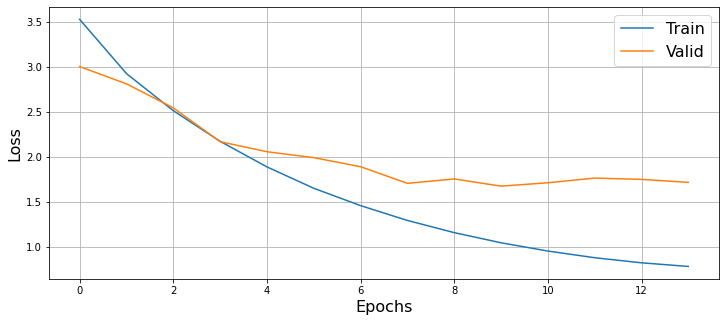

In [14]:
train(model, tokenizer, train_df, valid_df)

In [16]:
# Let's chat for 5 lines
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt').to(DEVICE)
    # print(new_user_input_ids)

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(
        bot_input_ids, max_length=200,
        pad_token_id=tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=100, 
        top_p=0.7,
        temperature = 0.8
    )
    
    # pretty print last ouput tokens from bot
    print("Bot: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:Hi
Bot:  hello, dean? you're a stupid head.
>> User:NO!!!
Bot: lisa, no one's calling you a stupidheaded head. you're just... 
>> User:Homer
Bot: please, please, please...
>> User:Who are you?
Bot:  uh... geraldo... simpson... oops.
>> User:Are you Homer?
Bot:  oops, thanks for dropping by.


In [17]:
model.save_pretrained('Homer_model')

In [18]:
tokenizer.save_pretrained('Homer_model')

('Homer_model\\vocab.json',
 'Homer_model\\merges.txt',
 'Homer_model\\special_tokens_map.json',
 'Homer_model\\added_tokens.json')

In [19]:
model = AutoModelWithLMHead.from_pretrained('Homer_model').to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained('Homer_model')

D:\Anaconda3\lib\site-packages\transformers\modeling_auto.py:781: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [20]:
# Let's chat for 5 lines
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt').to(DEVICE)

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids
    
    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(
        bot_input_ids, max_length=200,
        pad_token_id=tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=100, 
        top_p=0.7,
        temperature = 0.8
    )
    
    # pretty print last ouput tokens from bot
    print("Bot: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:Do you have children?
tensor([[ 5211,   345,   423,  1751,    30, 50256]], device='cuda:0')
tensor([[ 5211,   345,   423,  1751,    30, 50256]], device='cuda:0')
tensor([[ 5211,   345,   423,  1751,    30, 50256,  7456,    11,  1682,    11,
           356,   821,   407,  1107,  3501,   340,   674,  1266,  2823,    13,
         50256]], device='cuda:0')
tensor([ 7456,    11,  1682,    11,   356,   821,   407,  1107,  3501,   340,
          674,  1266,  2823,    13, 50256], device='cuda:0')
Bot: uh, actually, we're not really giving it our best shot.


KeyboardInterrupt: Interrupted by user